In [1]:
import pandas as pd

Folder_Path = r'data_part1'          
SaveFile_Name = r'all.csv'             
df = pd.read_csv(Folder_Path+'/' +"cleaned_head.csv")

In [2]:
groundtruthset = [["feature1","feature0"],
                  ["feature2","feature0"],
                  ["feature15","feature0"],
                  ["feature13","feature0"],
                  ["feature12","feature0"],
                  ["feature1","feature0"],
                  ["feature11","feature1"],
                  ["feature11","feature12"],
                  ["feature18","feature1"],
                  ["feature18","feature2"],
                  ["feature18","feature16"],
                  ["feature16","feature2"],
                  ["feature16","feature1"],
                  ["feature17","feature2"],
                  ["feature19","feature18"]]
                  #["feature60","feature18"], some bad data
# multi-variate pairs
#                   ["feature28_0","feature17"],
#                   ["feature28_1","feature17"],
#                   ["feature28_2","feature17"],
#                   ["feature28_3","feature17"],
#                   ["feature28_4","feature17"],
#                   ["feature28_5","feature17"],
#                   ["feature28_6","feature17"],
#                   ["feature28_7","feature17"],
                  
#                   ["feature36_0","feature17"],
#                   ["feature36_1","feature17"],
#                   ["feature36_2","feature17"],
#                   ["feature36_3","feature17"],
#                   ["feature36_4","feature17"],
#                   ["feature36_5","feature17"],
#                   ["feature36_6","feature17"],
#                   ["feature36_7","feature17"]]
                  
                  
#                   ["feature28_0","feature61_0"],
#                   ["feature28_1","feature61_1"],
#                   ["feature28_2","feature61_2"],
#                   ["feature28_3","feature61_3"],
#                   ["feature28_4","feature61_4"],
#                   ["feature28_5","feature61_5"],
#                   ["feature28_6","feature61_6"],
#                   ["feature28_7","feature61_7"],
                  
#                   ["feature36_0","feature69_0"],
#                   ["feature36_1","feature69_1"],
#                   ["feature36_2","feature69_2"],
#                   ["feature36_3","feature69_3"],
#                   ["feature36_4","feature69_4"],
#                   ["feature36_5","feature69_5"],
#                   ["feature36_6","feature69_6"],
#                   ["feature36_7","feature69_7"]
#                     ]
                  
#                  # ["feature44_0","feature77_0"],
#                  # ["feature44_1","feature77_1"],
#                   ["feature44_2","feature77_2"],
#                   ["feature44_3","feature77_3"],
#                   ["feature44_4","feature77_4"],
#                   ["feature44_5","feature77_5"],
#                   ["feature44_6","feature77_6"],
#                   ["feature44_7","feature77_7"],
                  
#                   ["feature52_0","feature85_0"],
#                   ["feature52_1","feature85_1"],
#                   ["feature52_2","feature85_2"],
#                   ["feature52_3","feature85_3"],
#                   ["feature52_4","feature85_4"],
#                   ["feature52_5","feature85_5"],
#                   ["feature52_6","feature85_6"],
#                   ["feature52_7","feature85_7"]]
                  

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler

from utils import *
device ="cpu"

In [4]:
from sklearn.metrics import roc_auc_score
from cdt.causality.pairwise import ANM, CDS, IGCI, RECI
from collections import Counter
import argparse
import os

EPSILON = 1e-8

def score(y_true, predictions):
    ret = (roc_auc_score(y_true == 1, predictions) + roc_auc_score(y_true == -1, -predictions)) / 2
    return round(ret, 3)

existing_methods = dict(
    ANM=ANM(),
    CDS=CDS(),
    IGCI=IGCI(),
    RECI=RECI()
)

def cond_dist(x, y, max_dev=3):
    vmax =  2 * max_dev
    vmin = -2 * max_dev

    x = (x - x.mean()) / (x.std() + EPSILON)
    t = x[np.abs(x) < max_dev]
    x = (x - t.mean()) / (t.std() + EPSILON)
    xd = np.round(x * 2)
    xd[xd > vmax] = vmax
    xd[xd < vmin] = vmin

    x_count = Counter(xd)
    vrange = range(vmin, vmax + 1)

    pyx = []
    for x in x_count:
        if x_count[x] > 12:
            yx = y[xd == x]
            yx = (yx - np.mean(yx)) / (np.std(yx) + EPSILON)
            yx = np.round(yx * 2)
            yx[yx > vmax] = vmax
            yx[yx < vmin] = vmin
            count_yx = Counter(yx)
            pyx_x = np.array([count_yx[i] for i in vrange], dtype=np.float64)
            pyx_x = pyx_x / pyx_x.sum()
            pyx.append(pyx_x)
    return pyx

def CKL(A, B, **kargs):
    '''Causal score via Kullback-Leibler divergence'''
    pyx = cond_dist(A, B, **kargs)
    if len(pyx) == 0:
        return 0
    pyx = np.array(pyx) # axis 0: x; axis 1: y
    mean_y = pyx.mean(axis=0)
    return (pyx * np.log((pyx + EPSILON) / (mean_y + EPSILON))).sum(axis=1).mean()

def CKM(A, B, **kargs):
    '''Causal score via Kolmogorov metric'''
    pyx = cond_dist(A, B, **kargs)
    if len(pyx) == 0:
        return 0
    pyx = np.array(pyx) # axis 0: x; axis 1: y
    mean_y = pyx.mean(axis=0).cumsum()
    pyx = pyx.cumsum(axis=1)

    return np.abs(pyx - mean_y).max(axis=1).mean()

def CHD(A, B, **kargs):
    '''Causal score via Hellinger Distance'''
    pyx = cond_dist(A, B, **kargs)
    if len(pyx) == 0:
        return 0
    pyx = np.array(pyx) # axis 0: x; axis 1: y
    mean_y = pyx.mean(axis=0)
    return (((pyx ** 0.5 - mean_y ** 0.5) ** 2).sum(axis=1) ** 0.5).mean()

def CCS(A, B, **kargs):
    '''Causal score via Chi-Squared distance'''
    pyx = cond_dist(A, B, **kargs)
    if len(pyx) == 0:
        return 0
    pyx = np.array(pyx) # axis 0: x; axis 1: y
    mean_y = pyx.mean(axis=0)
    return ((pyx - mean_y) ** 2 / (mean_y + EPSILON)).sum(axis=1).mean()

def CTV(A, B, **kargs):
    '''Causal score via Total Variation distance'''
    pyx = cond_dist(A, B, **kargs)
    if len(pyx) == 0:
        return 0
    pyx = np.array(pyx) # axis 0: x; axis 1: y
    mean_y = pyx.mean(axis=0)
    return 0.5 * np.abs(pyx - mean_y).sum(axis=1).mean()

def causal_score(variant, A, B, **kargs):
    variant = eval(variant)
    return variant(B, A, **kargs) - variant(A, B, **kargs)

def predict(method, data, **kargs):
    if method in existing_methods:
        return data.apply(lambda row: existing_methods[method].predict_proba((row['A'], row['B'])), axis=1)
    return data.apply(lambda row: causal_score(method, row['A'], row['B'], **kargs), axis=1)

def parse_numeric(df):
    parse_cell = lambda cell: np.fromstring(cell.replace('[', '').replace(']', ''), dtype=np.float64, sep=" ")
    df = df.applymap(parse_cell)
    return df

def write_predictions(directory, method, dataset, index, preds):
    if directory:
        os.makedirs(directory, exist_ok=True)
        df = pd.DataFrame(dict(SampleID=index, Target=preds))
        df.to_csv(f'{directory}/{dataset}_{method}.csv', index=False)

def compare_all():
    all_data = []
    results = []
    for dataset in args.datasets + ['All']:
        print(dataset.center(20, '-'))
        if dataset == 'All':
            data = pd.concat(all_data)
        else:
            data = pd.read_csv(f'data/{dataset}.csv', index_col='SampleID')
            data[['A', 'B']] = parse_numeric(data[['A', 'B']])
            all_data.append(data)
        print(f'{data.shape = }')
        targets = data['Target']

        for method in args.methods:
            predictions = predict(method, data, max_dev=args.maxdev)
            auc = score(targets, predictions)
            print(method.ljust(5, ' '), auc)
            results.append(dict(Method=method, Dataset=dataset, Score=auc))
            # write_predictions(args.out, method, dataset, targets.index, predictions)

    df = pd.DataFrame(results)
    df = pd.pivot(df, index='Method', columns='Dataset', values='Score')
    df.to_csv(args.out)

def test_hyperparameters():
    param_grid = [dict(max_dev=max_dev) for max_dev in range(1, 6)]
    all_data = []
    for dataset in args.datasets:
        data = pd.read_csv(f'data/{dataset}.csv', index_col='SampleID')
        data[['A', 'B']] = parse_numeric(data[['A', 'B']])
        all_data.append(data)
    data = pd.concat(all_data)
    targets = data['Target']

    results = []
    for params in param_grid:
        print(str(params).ljust(40, '-'))
        for method in args.methods:
            predictions = predict(method, data, **params)
            auc = score(targets, predictions)
            print(method.ljust(6, ' '), auc)
            results.append(dict(Method=method, **params, Score=auc))

    df = pd.DataFrame(results)
    df.to_csv(args.out)



No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
acc_rec = []
for seed in range(50):
    print("seed:",seed)
    
    # sample 1000 data from the whole dataset for lower computational burden
    newdf =  pd.DataFrame(columns=["A","B"])
    for i in range(len(groundtruthset)):
        try:
            pair = df[groundtruthset[i]].dropna().sample(n=1000, random_state=seed) #200,41
            newdf = newdf.append({"A":pair.values[:,0],"B":pair.values[:,1]}, ignore_index=True)
        except:
            print(groundtruthset[i])
            pass
        
    # some baselines in causal discovery tool cdt python package. Accuracy is printed.    
    for obj in [ANM(),CDS(),IGCI(),RECI()]:
        cnt = 0
        for i in range(len(groundtruthset)):
            try:
                score = obj.predict_proba(newdf.iloc[i])
                if score>0:
                    cnt= cnt+1
            except:
                print(i,"xxxxx")
        acc_rec.append(cnt/len(groundtruthset))
        print(obj,cnt/len(groundtruthset))
        
    # CHD is one method of CDCI in "Bivariate Causal Discovery via Conditional Divergence"
    cnt = 0
    for i in range(len(groundtruthset)):
        a =CHD(newdf.iloc[i]["A"],newdf.iloc[i]["B"])
        b =CHD(newdf.iloc[i]["B"],newdf.iloc[i]["A"])
    #     print(a,b)
        if a<b:
            cnt = cnt+1
    acc_rec.append(cnt/len(groundtruthset))
    print("CHD:",cnt/len(groundtruthset))
    
    # MCPNL proposed in "Post-Nonlinear Causal Relationship with Finite Samples: A Maximal Correlation Perspective"
    cnt = 0
    for i in range(len(groundtruthset)):
        try:
            a =MCPNL(newdf.iloc[i]["A"],newdf.iloc[i]["B"])
            b =MCPNL(newdf.iloc[i]["B"],newdf.iloc[i]["A"])
        except:
            a,b = 0,0
    #     print(i,a,b)
        if a<b:
            cnt = cnt+1
    acc_rec.append(cnt/len(groundtruthset))
    print("MCPNL:",cnt/len(groundtruthset))

seed: 0
<cdt.causality.pairwise.ANM.ANM object at 0x7fd4009a9880> 0.7333333333333333
<cdt.causality.pairwise.CDS.CDS object at 0x7fd392fe60d0> 0.6
<cdt.causality.pairwise.IGCI.IGCI object at 0x7fd3903c9f40> 0.7333333333333333
<cdt.causality.pairwise.RECI.RECI object at 0x7fd3903c9fa0> 0.4666666666666667
CHD: 0.6666666666666666
MCPNL: 0.6666666666666666
seed: 1
<cdt.causality.pairwise.ANM.ANM object at 0x7fd4009a9880> 0.6666666666666666
<cdt.causality.pairwise.CDS.CDS object at 0x7fd4c405adc0> 0.6666666666666666
<cdt.causality.pairwise.IGCI.IGCI object at 0x7fd3903c9fd0> 0.7333333333333333
<cdt.causality.pairwise.RECI.RECI object at 0x7fd3903c99a0> 0.4666666666666667
CHD: 0.5333333333333333
MCPNL: 0.6
seed: 2
<cdt.causality.pairwise.ANM.ANM object at 0x7fd4009a9880> 0.6666666666666666
<cdt.causality.pairwise.CDS.CDS object at 0x7fd383788790> 0.5333333333333333
<cdt.causality.pairwise.IGCI.IGCI object at 0x7fd3903751c0> 0.7333333333333333
<cdt.causality.pairwise.RECI.RECI object at 0x7fd

MCPNL: 0.5333333333333333
seed: 24
<cdt.causality.pairwise.ANM.ANM object at 0x7fd390375d90> 0.6
<cdt.causality.pairwise.CDS.CDS object at 0x7fd3903c9f40> 0.4666666666666667
<cdt.causality.pairwise.IGCI.IGCI object at 0x7fd4aadced90> 0.6666666666666666
<cdt.causality.pairwise.RECI.RECI object at 0x7fd4aadceeb0> 0.4666666666666667
CHD: 0.4666666666666667
MCPNL: 0.3333333333333333
seed: 25
<cdt.causality.pairwise.ANM.ANM object at 0x7fd4c405adc0> 0.6666666666666666
<cdt.causality.pairwise.CDS.CDS object at 0x7fd4aadce0d0> 0.5333333333333333
<cdt.causality.pairwise.IGCI.IGCI object at 0x7fd4aadced30> 0.7333333333333333
<cdt.causality.pairwise.RECI.RECI object at 0x7fd4aadce400> 0.4
CHD: 0.4666666666666667
MCPNL: 0.8
seed: 26
<cdt.causality.pairwise.ANM.ANM object at 0x7fd4aadcfbb0> 0.4666666666666667
<cdt.causality.pairwise.CDS.CDS object at 0x7fd4aadcf1f0> 0.6666666666666666
<cdt.causality.pairwise.IGCI.IGCI object at 0x7fd4aadf5fa0> 0.7333333333333333
<cdt.causality.pairwise.RECI.RECI o

MCPNL: 0.5333333333333333
seed: 48
<cdt.causality.pairwise.ANM.ANM object at 0x7fd4aade6700> 0.6666666666666666
<cdt.causality.pairwise.CDS.CDS object at 0x7fd4aade6250> 0.5333333333333333
<cdt.causality.pairwise.IGCI.IGCI object at 0x7fd4aade6880> 0.7333333333333333
<cdt.causality.pairwise.RECI.RECI object at 0x7fd4aaddb130> 0.4666666666666667
CHD: 0.5333333333333333
MCPNL: 0.5333333333333333
seed: 49
<cdt.causality.pairwise.ANM.ANM object at 0x7fd4aade63a0> 0.8
<cdt.causality.pairwise.CDS.CDS object at 0x7fd4aade6fd0> 0.5333333333333333
<cdt.causality.pairwise.IGCI.IGCI object at 0x7fd4aade6700> 0.7333333333333333
<cdt.causality.pairwise.RECI.RECI object at 0x7fd4aade67c0> 0.4
CHD: 0.6
MCPNL: 0.6


In [7]:
data = np.array(acc_rec).reshape(50,6)

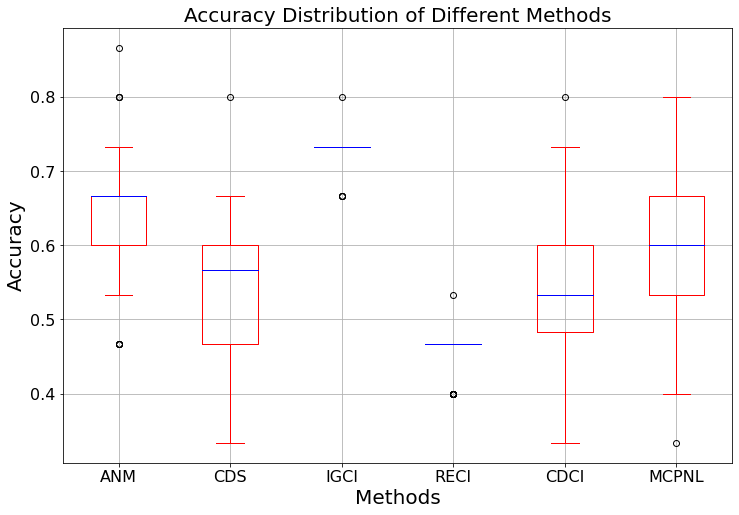

In [8]:
import seaborn as sns
num_seeds, num_methods = data.shape


# 将numpy矩阵转换为pandas DataFrame
methods = ['ANM', 'CDS', 'IGCI', 'RECI', 'CDCI', 'MCPNL']
df = pd.DataFrame(data, columns=methods)


# 绘制箱线图
plt.figure(figsize=(12, 8))
boxplot = df.boxplot(color=dict(boxes='r', whiskers='r', medians='b', caps='r'))


# plt.figure(figsize=(20, 6))
# df.boxplot()
plt.title('Accuracy Distribution of Different Methods', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Methods', fontsize=20)

# 设置x轴和y轴刻度字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('accuracy_distribution_boxplot.pdf')
plt.show()